# Set global parameters


The OptimUS library provides functionality to simulate acoustic wave propagation in unbounded domains with homogeneous scatterers. This notebook demonstrates how to set global parameters of the library.


## Import the OptimUS library

Load the OptimUS library.

In [2]:
import optimus

## View global parameters

The OptimUS library uses default settings in a variety of routines. The global parameters can be viewed and changed in the ```optimus.global_parameters``` class instance.

In [3]:
optimus.global_parameters.print()


Verbosity parameter: False

BEM parameters:
 Matrix assembly type:  hmat
  H-matrix epsilon for boundary operators: 0.001
  H-matrix maximum rank for boundary operators: 30
  H-matrix maximum block size for boundary operators: 1000000
 Field assembly type:  dense
 Numerical quadrature order.
  Double integration for boundary operators in the matrix.
   Self interaction: 6
   Near interaction: 4
   Medium interaction: 3
   Far interaction: 2
  Single integration for potential operators for the field.
   Near interaction: 4
   Medium interaction: 3
   Far interaction: 2

Linear algebra parameters:
 Linear solver: gmres
 Tolerance: 1e-05
 Maximum number of iterations: 1000
 Number of iterations before restart: 1000

Incident field parallel processing parameters:
 Parallelisation method: numba

Preconditioning parameters:
 OSRC preconditioner.
  Number of Padé expansion terms: 4
  Branch cut angle for Padé series: 1.0471975511965976
  Wavenumber: int
  Damped wavenumber: None

Postprocess

## Specify the BEM parameters

The OptimUS library uses a Boundary Element Method (BEM) to solve acoustic wave propagation. The BEMPP library performs the calculation of the system matrix and the fields. The numerical parameters for the calculation of the integral operators can be set with the functions available in the module ```optimus.global_parameters.bem```. Furthermore, all BEMPP parameters can be retrieved as ```optimus.global_parameters.bem.bempp_parameters```.

For example, the BEMPP library (version 3) allows for calculation of the integral operators with hierarchical matrix compression. In general, using $H$-matrix compression reduces the memory consumption but introduces a controllable error $\epsilon$ for matrix-vector multiplications. This fast algorithm is recommended when the problem size is large while dense matrix arithmetic tends to be faster for smaller problems.

For more accurate calculations with the $H$-matrix compression, the $\epsilon$ can be set to lower values as follows. This will be at the expense of more RAM consumption, though.

In [4]:
optimus.global_parameters.bem.set_matrix_hmat(eps=1e-5)
optimus.global_parameters.bem.print()

Matrix assembly type:  hmat
 H-matrix epsilon for boundary operators: 1e-05
 H-matrix maximum rank for boundary operators: 30
 H-matrix maximum block size for boundary operators: 1000000
Field assembly type:  dense
Numerical quadrature order.
 Double integration for boundary operators in the matrix.
  Self interaction: 6
  Near interaction: 4
  Medium interaction: 3
  Far interaction: 2
 Single integration for potential operators for the field.
  Near interaction: 4
  Medium interaction: 3
  Far interaction: 2


Since this tutorial uses a coarse mesh, let us change the default $H$-matrix compression of the matrix to dense mode.

In [5]:
optimus.global_parameters.bem.set_matrix_assembly_type("dense")
optimus.global_parameters.bem.print()

Matrix assembly type:  dense
Field assembly type:  dense
Numerical quadrature order.
 Double integration for boundary operators in the matrix.
  Self interaction: 6
  Near interaction: 4
  Medium interaction: 3
  Far interaction: 2
 Single integration for potential operators for the field.
  Near interaction: 4
  Medium interaction: 3
  Far interaction: 2


## Specify the wave model

Let us consider a standard test case of a spherical bone embedded in water, excited by a plane wave, and solved by a standard BEM model.

In [6]:
source = optimus.source.create_planewave(frequency=1000)
geometry = optimus.geometry.shapes.Sphere(element_size=0.4)
material_ext = optimus.material.load_material('water')
material_int = optimus.material.load_material('bone (cortical)')

In [7]:
model = optimus.model.create_acoustic_model(source, geometry, material_ext, material_int)

## Simulate the wave model with different global parameters for the linear solver

The BEM model is solved with the GMRES algorithm. As an iterative linear solver, one can specify the tolerance and the maximum number of iterations. Let us solve the model with the default settings and then change them.

In [8]:
model.solve()

In [9]:
print("The global parameters for the linear algebra are as follows.\n")
optimus.global_parameters.linalg.print()
print("\nThe model was solved in", model.iteration_count, "iterations.")

The global parameters for the linear algebra are as follows.

Linear solver: gmres
Tolerance: 1e-05
Maximum number of iterations: 1000
Number of iterations before restart: 1000

The model was solved in 25 iterations.


Let us change the tolerance of the GMRES algorithm. Generally speaking, a smaller tolerance gives a more accurate approximation to the surface potentials but requires more iterations from the linear solver.

In [10]:
optimus.global_parameters.linalg.tol = 1e-9

In [11]:
model.solve()

In [12]:
print("The global parameters for the linear algebra are as follows.\n")
optimus.global_parameters.linalg.print()
print("\nThe model was solved in", model.iteration_count, "iterations.")

The global parameters for the linear algebra are as follows.

Linear solver: gmres
Tolerance: 1e-09
Maximum number of iterations: 1000
Number of iterations before restart: 1000

The model was solved in 37 iterations.


Let us change the maximum number of iterations that can be used by GMRES. A smaller value limits the simulation time of the linear solver. However, if this maximum is reached, the solution might not be accurate since the final estimate has a larger residual than the specified tolerance.

In [13]:
optimus.global_parameters.linalg.maxiter = 10

In [14]:
model.solve()

../optimus/model/linalg.py:96: RuntimeWarning: The GMRES solver stopped at the maximum number of 10 iterations.
  RuntimeWarning,


In [15]:
print("The global parameters for the linear algebra are as follows.\n")
optimus.global_parameters.linalg.print()
print("\nThe model was solved in", model.iteration_count, "iterations.")

The global parameters for the linear algebra are as follows.

Linear solver: gmres
Tolerance: 1e-09
Maximum number of iterations: 10
Number of iterations before restart: 1000

The model was solved in 10 iterations.


## Visualisation of the acoustic field

The acoustic field can be calculated in arbitrary points. Let us visualize the field on a grid in the plane $z=0$.

In [16]:
postprocess_plane = optimus.postprocess.VisualisePlane(model)
postprocess_plane.create_computational_grid(bounding_box=[-3, 4, -3, 3])
postprocess_plane.compute_fields()

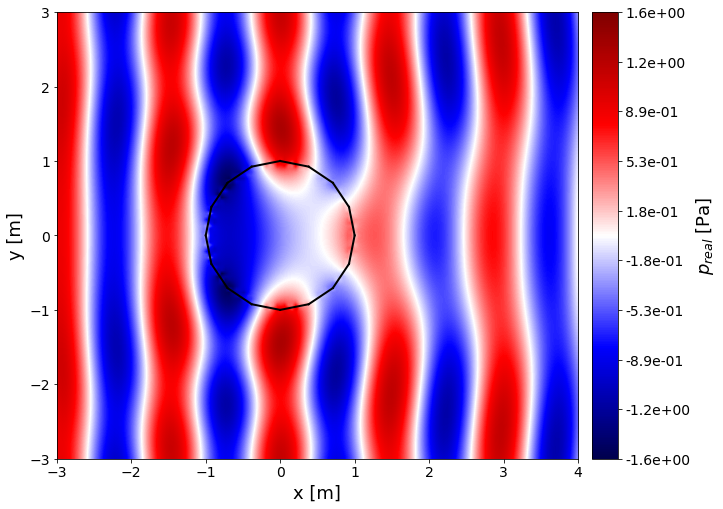

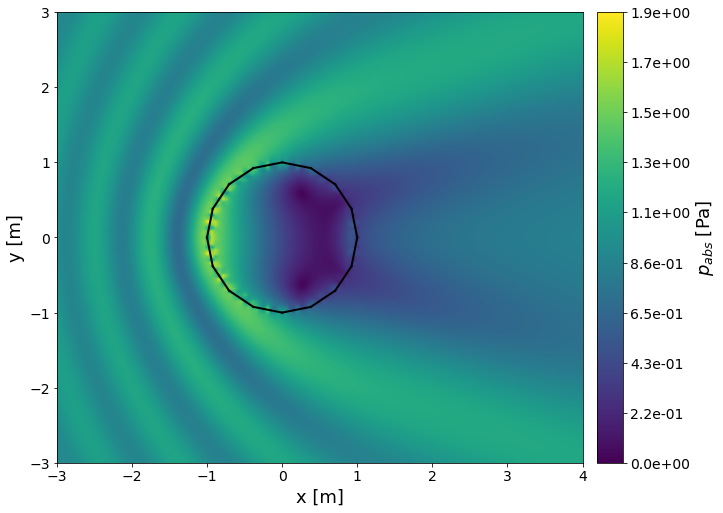

In [17]:
%matplotlib inline
figs = optimus.postprocess.plot_pressure_field(postprocess_plane)